In [77]:
data_path = '../data/topic6/diving*.csv'
fq_path = '../data/topic6/topic6_NewFrequency.csv'
tr_path = '../data/topic6/topic6_TextRank.csv'
save_path = '/topic6'
filename = '/topic' + save_path[-1] + '_keyword_t-SNE.png'


/Users/shimgahyeon/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/shimgahyeon/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


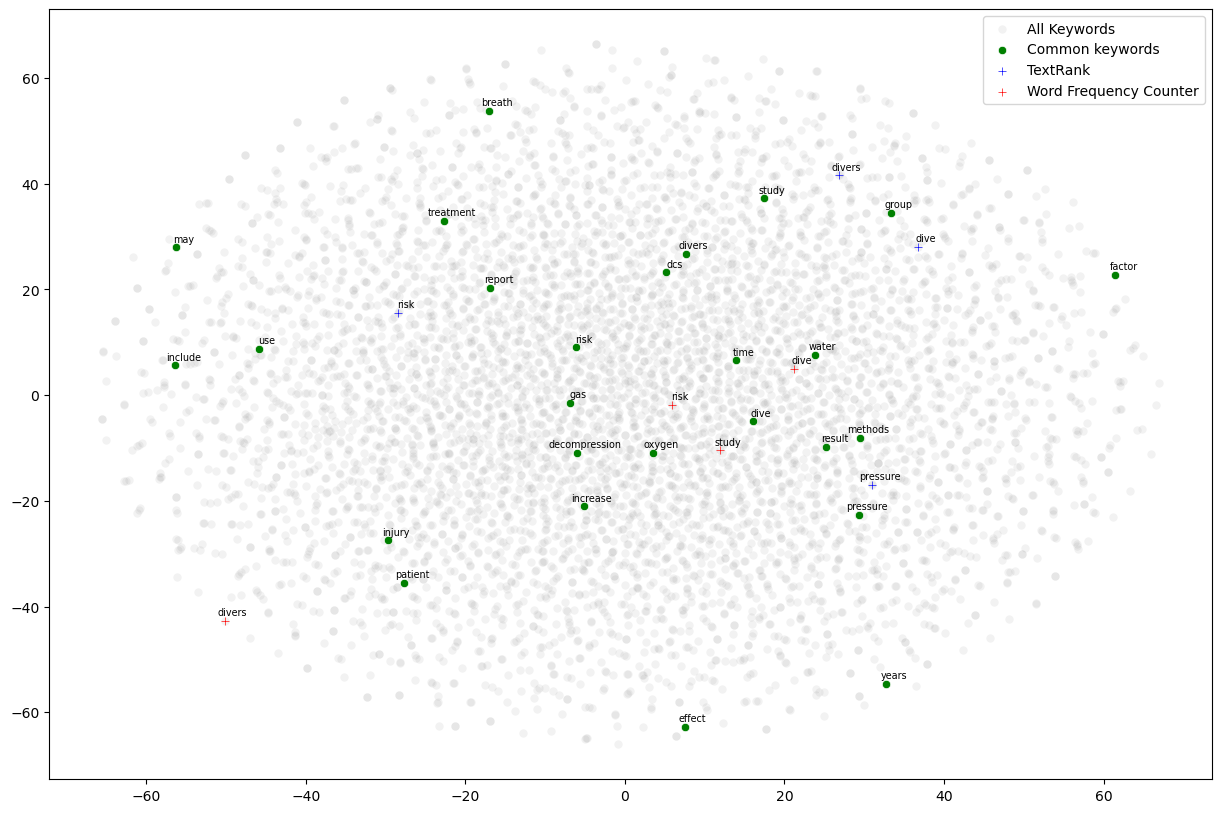

In [78]:
import sys
import os
import argparse
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from gensim.corpora.dictionary import Dictionary
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
import seaborn as sns

sys.path.insert(0, '../')
import preprocess_csv as preprocess


def tokenizer(text):
    '''
    apply tokenizer
    '''
    cachedStopWords = stopwords.words("english")
    RegTok = RegexpTokenizer("[\w']{3,}")
    english_stops = set(stopwords.words('english'))
    tokens = RegTok.tokenize(text.lower())
    # stopwords 제외
    words = [word for word in tokens if (word not in english_stops) and len(word) > 2]
    
    stemmer = PorterStemmer()
    word_token = [stemmer.stem(i) for i in words]
    
    return word_token


def get_word_index(path, model):
    stemmer = PorterStemmer()

    df = pd.read_csv(path)
    words = df['keyword']
    index = []
    for word in words:
        index.append(model.wv.index2word.index(stemmer.stem(word)))

    return words, index


def draw_tsne(fig, x, y, color, alpha):
    # 한글 깨짐
    plt.figure(figsize=(10, 6))
    plt.rcParams['axes.unicode_minus'] = False
    # if you use MacOS
    plt.rcParams['font.family'] = 'AppleGothic'
    # else if you use Windows
    # plt.rcParams['font.family'] = 'Malgun Gothic'

    fig = sns.scatterplot(
        x=x, y=y,
        legend="full",
        color=color,
        alpha=alpha
    )
    
    if title is not None:
        fig.set(title=title)
    
    return fig.get_figure()



def main():
    # filename = '/topic' + save_path[-1] + '_keyword_t-SNE.png'
    df = pd.read_csv(data_path)
    papers = preprocess.extract_text(df)
    texts = [tokenizer(paper) for paper in papers]

    # size: 임베딩된 벡터 차원
    # window: context window 크기
    # min_count: 단어 최소 빈도수
    # workers: 학습을 위한 프로세스 수
    # sg: 0은 CBOW, 1은 Skip-Gram
    model = Word2Vec(sentences=texts, size=100, window=5, min_count=2, workers=-1, sg=1)

    # load tsne model
    tsne_model = TSNE(perplexity=40, n_components=2, n_iter=2500, random_state=7)

    full_tsne_2 = tsne_model.fit_transform(model.wv.vectors)
    full_x = full_tsne_2[:, 0]
    full_y = full_tsne_2[:, 1]
    

    # save textrank tsne values
    tr_words, tr_index = get_word_index(tr_path, model)

    # save frequency tsne values
    fq_words, fq_index = get_word_index(fq_path, model)

    # find common indexes
    common = []
    for i in tr_index:
        if i in fq_index:
            common.append(i)

    common_x = []; common_y = []; common_words_ = []
    for i in common:
        common_x.append(full_tsne_2[i, 0])
        common_y.append(full_tsne_2[i, 1])

    tr_x = []; tr_y = []; tr_words_ = []
    for i in tr_index:
        if not(i in common):
            tr_x.append(full_tsne_2[i, 0])
            tr_y.append(full_tsne_2[i, 1])

    fq_x = []; fq_y = []; fq_words_ = []
    for i in fq_index:
        if not(i in common):
            fq_x.append(full_tsne_2[i, 0])
            fq_y.append(full_tsne_2[i, 1])
            
    ## draw figures
    fig = plt.figure(figsize=(15, 10))
    # drwaw tnse to full vectors
    sns.scatterplot(
        x=full_x, y=full_y,
        legend="full",
        color='gray',
        alpha=0.1
    )
    fig.set_label("All Keywords")

    # draw common index 
    fig = sns.scatterplot(
        x=common_x, y=common_y,
        legend="full",
        color='g',
        alpha=1
    )
    fig.set_label("Common Keywords")

    # draw tsne to textrank words
    fig = sns.scatterplot(
        x=tr_x, y=tr_y,
        legend="full",
        color='b',
        marker='+',
        alpha=1
    )
    fig.set_label("Keywords of TextRank")

    # draw tsne to frequency words
    sns.scatterplot(
        x=fq_x, y=fq_y,
        legend="full",
        color='r',
        marker='+',
        alpha=1
    )
    fig.set_label("Keywords of Word Frequency Counter")

    # # add textrank words
    for i in range(len(common)):
        fig.text(common_x[i]+1, common_y[i]+1, tr_words[i], alpha=1, fontsize='x-small', horizontalalignment='center')

    for i in range(len(tr_x)):
        fig.text(tr_x[i]+1, tr_y[i]+1, tr_words[i], alpha=1, fontsize='x-small', horizontalalignment='center')
    # # add frequency words
    for i in range(len(fq_x)):
        fig.text(fq_x[i]+1, fq_y[i]+1, fq_words[i], alpha=1, fontsize='x-small', horizontalalignment='center')

    fig.legend(labels=['All Keywords', 'Common keywords', 'TextRank', 'Word Frequency Counter'], bbox_to_anchor = (1,1))

    # plt.show()
    fig = fig.get_figure()
    fig.savefig('../figure' + save_path + filename)
    
main()

In [25]:
df1 = pd.DataFrame()
df1['word'] = tr_words
df1['index'] = tr_index

In [26]:
df2 = pd.DataFrame()
df2['word'] = fq_words
df2['index'] = fq_index

In [34]:
df = pd.concat([df1, df2], axis=1)
df

,word,index,word,index
0,robots,0,robots,0
1,patients,1,patients,1
2,use,2,use,2
3,study,4,surgery,3
4,surgery,3,study,4
5,result,5,result,5
6,outcomes,6,outcomes,6
7,compare,8,surgical,7
8,surgical,7,compare,8
9,perform,9,perform,9


In [54]:
import numpy as np

# save textrank tsne values
tr_words, tr_index = get_word_index(tr_path, model)

# save frequency tsne values
fq_words, fq_index = get_word_index(fq_path, model)

# find common indexes
common = []
for i in tr_index:
    if i in fq_index:
        common.append(i)
        
common_x = []; common_y = []; common_words_ = []
for i in common:
    common_x.append(full_tsne_2[i, 0])
    common_y.append(full_tsne_2[i, 1])
        
tr_x = []; tr_y = []; tr_words_ = []
for i in tr_index:
    if not(i in common):
        tr_x.append(full_tsne_2[i, 0])
        tr_y.append(full_tsne_2[i, 1])
    
fq_x = []; fq_y = []; fq_words_ = []
for i in fq_index:
    if not(i in common):
        fq_x.append(full_tsne_2[i, 0])
        fq_y.append(full_tsne_2[i, 1])

In [57]:
common

[0,
 1,
 2,
 4,
 3,
 5,
 6,
 8,
 7,
 9,
 10,
 11,
 15,
 14,
 12,
 16,
 17,
 13,
 21,
 20,
 24,
 27,
 18,
 26,
 28,
 29,
 22]

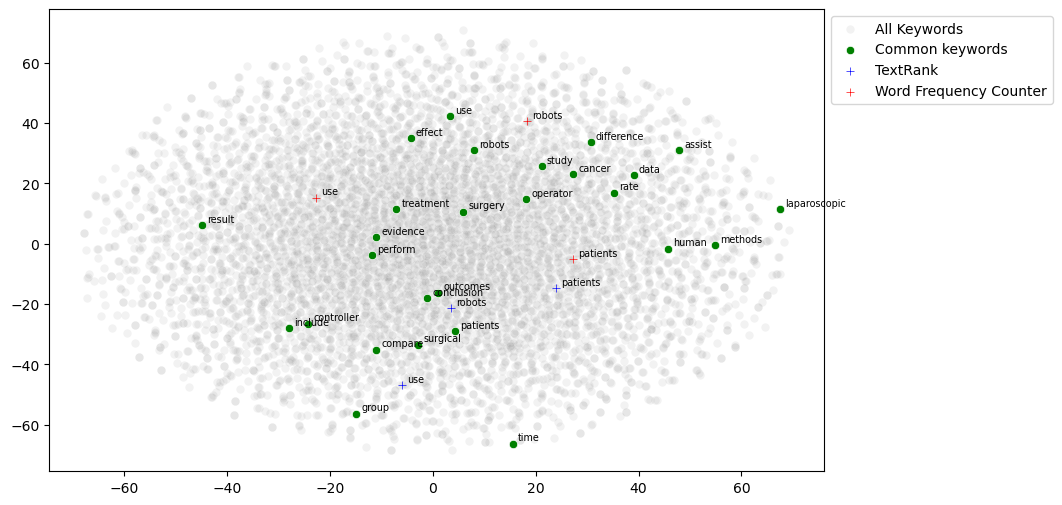

In [64]:
## draw figures
fig = plt.figure(figsize=(10, 6))
# drwaw tnse to full vectors
sns.scatterplot(
    x=full_x, y=full_y,
    legend="full",
    color='gray',
    alpha=0.1
)
fig.set_label("All Keywords")

# draw common index 
fig = sns.scatterplot(
    x=common_x, y=common_y,
    legend="full",
    color='g',
    alpha=1
)
fig.set_label("Common Keywords")

# draw tsne to textrank words
fig = sns.scatterplot(
    x=tr_x, y=tr_y,
    legend="full",
    color='b',
    marker='+',
    alpha=1
)
fig.set_label("Keywords of TextRank")

# draw tsne to frequency words
sns.scatterplot(
    x=fq_x, y=fq_y,
    legend="full",
    color='r',
    marker='+',
    alpha=1
)
fig.set_label("Keywords of Word Frequency Counter")

# # add textrank words
for i in range(len(common)):
    fig.text(common_x[i]+1, common_y[i]+1, tr_words[i], alpha=1, fontsize='x-small', horizontalalignment='left')

for i in range(len(tr_x)):
    fig.text(tr_x[i]+1, tr_y[i]+1, tr_words[i], alpha=1, fontsize='x-small', horizontalalignment='left')
# # add frequency words
for i in range(len(fq_x)):
    fig.text(fq_x[i]+1, fq_y[i]+1, fq_words[i], alpha=1, fontsize='x-small', horizontalalignment='left')

fig.legend(labels=['All Keywords', 'Common keywords', 'TextRank', 'Word Frequency Counter'], bbox_to_anchor = (1,1))

# plt.show()
fig = fig.get_figure()
fig.savefig('../figure' + save_path + filename)